# Jet Energy Correction Computations

In [1]:
import awkward as ak
import numpy as np
import coffea
import uproot
import hist
import vector
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from distributed.diagnostics.plugin import UploadDirectory
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import pickle
import correctionlib
from coffea.analysis_tools import PackedSelection
from dask.distributed import Client
from scipy.optimize import curve_fit
import csv
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
with open("pkl_files/QCD_pt_response_NEW.pkl", "rb") as f:
    output = pickle.load(f)

In [3]:
output['cutflow'].keys() 

dict_keys(['2018', '2017', '2016APV', '2016'])

### Loading and Plotting PKL File Output

Let's start by plotting the histograms that contain data for the ratio of reconstructed jet $p_{T}$ to generated jet $p_{T}$; we use the `output["pt_reco_over_gen"]` key and project it to `dataset` and the variable of interest, such as `.project("dataset", "pt")`, `.project("dataset", "frac")`, `.project("dataset", "eta")`, or `.project("dataset", "pileup")`, for example. We plot two graphs for each varible, one with pileup weights using `GetPUSF()` in our processor, and one without the weights.

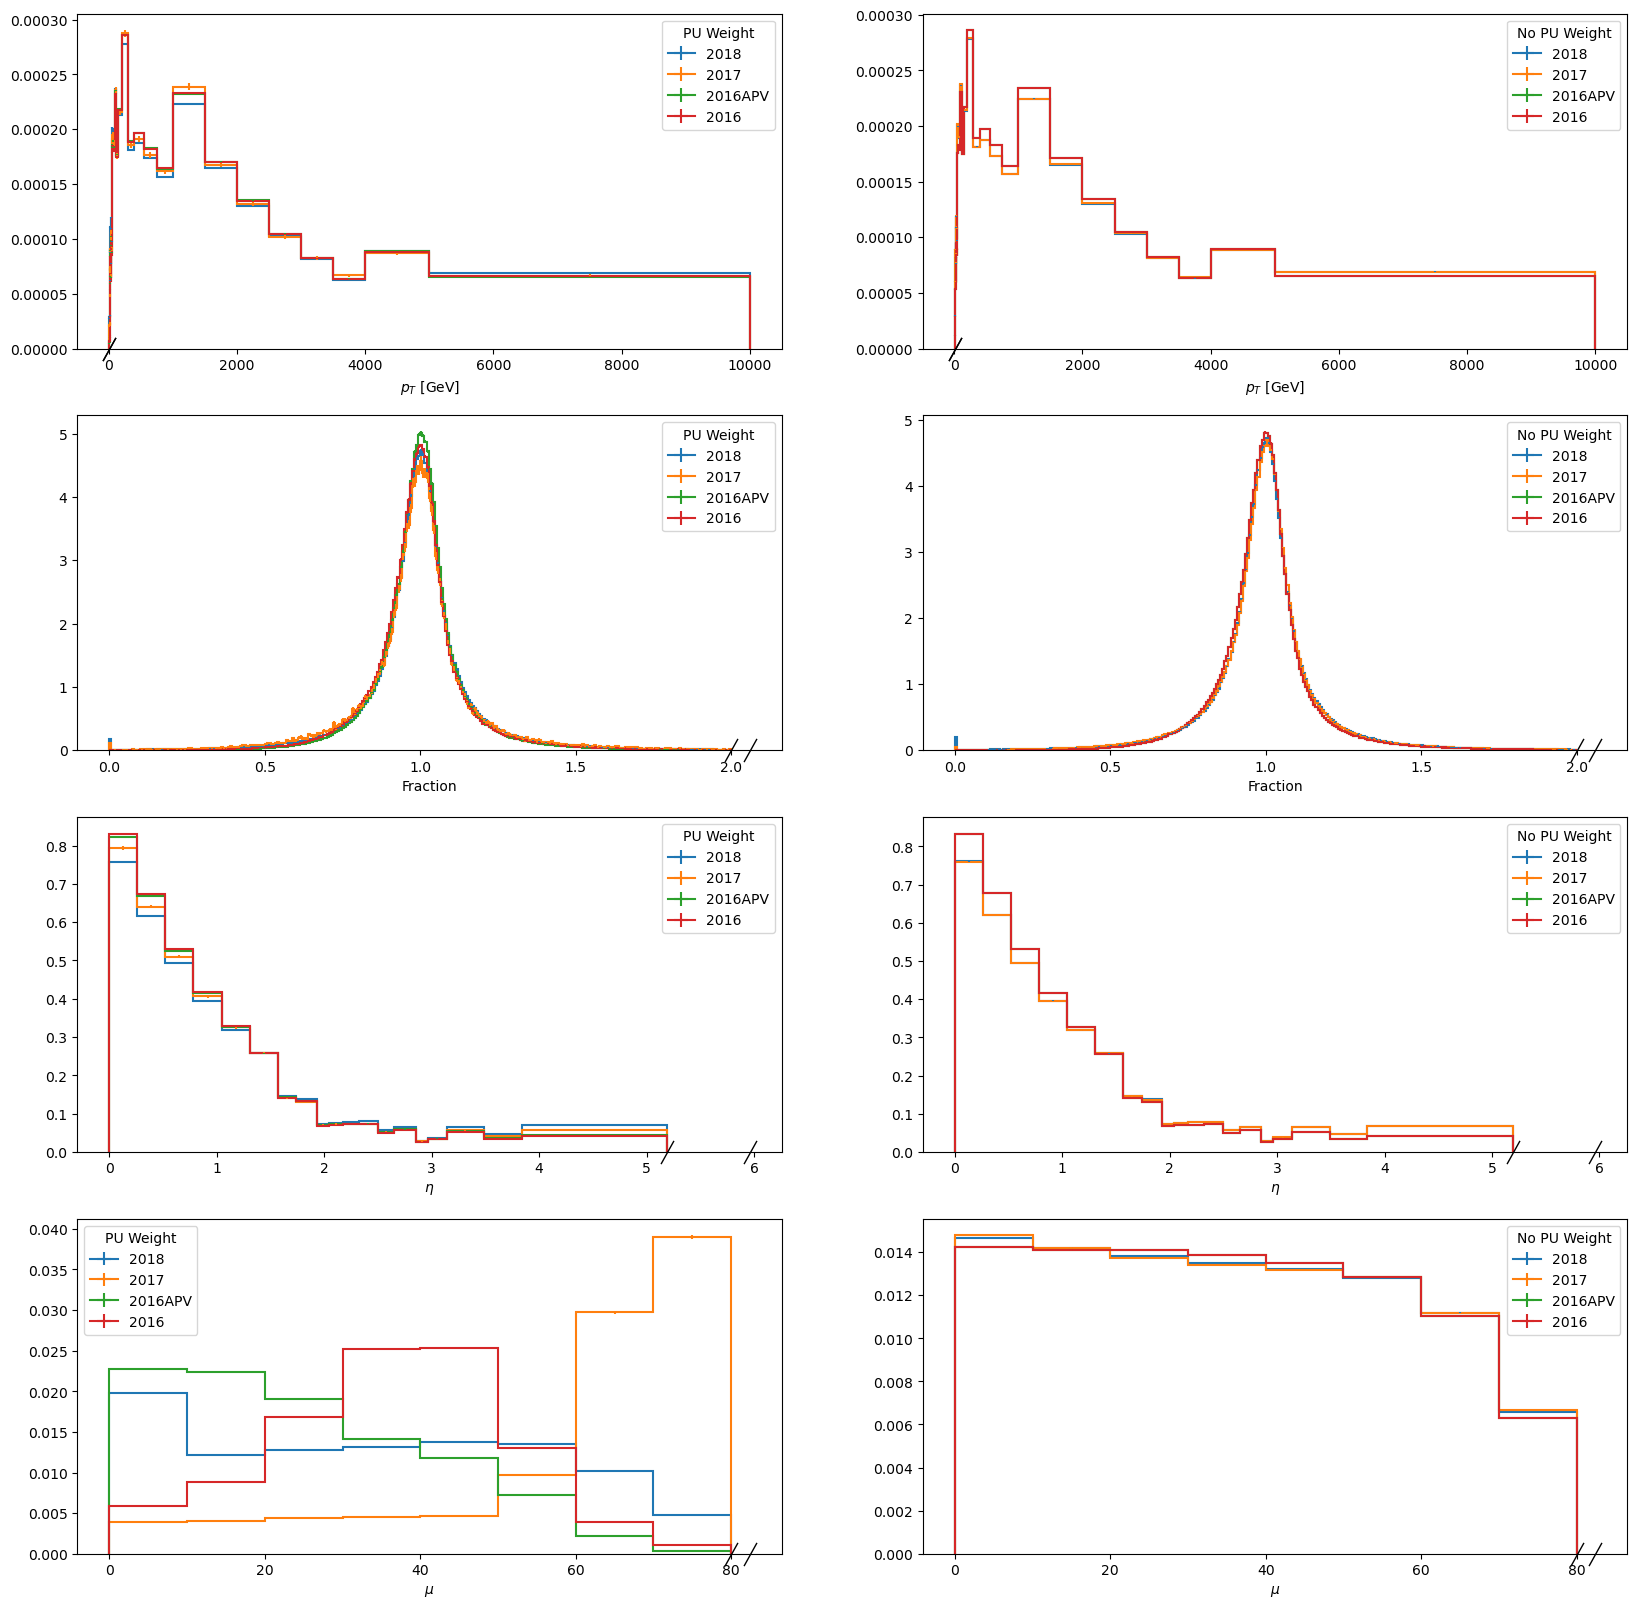

In [4]:
fig, axs = plt.subplots(4, 2, figsize=(20, 20))

output["pt_reco_over_gen"].project('dataset', 'pt').plot(ax=axs[0, 0], density=True)
output["pt_reco_over_gen_noweight"].project('dataset', 'pt').plot(ax=axs[0, 1], density=True)

output["pt_reco_over_gen"].project('dataset', 'frac').plot(ax=axs[1, 0], density=True)
output["pt_reco_over_gen_noweight"].project('dataset', 'frac').plot(ax=axs[1, 1], density=True)

output["pt_reco_over_gen"].project('dataset', 'eta').plot(ax=axs[2, 0], density=True)
output["pt_reco_over_gen_noweight"].project('dataset', 'eta').plot(ax=axs[2, 1], density=True)

output["pt_reco_over_gen"].project('dataset', 'pileup').plot(ax=axs[3, 0], density=True)
output["pt_reco_over_gen_noweight"].project('dataset', 'pileup').plot(ax=axs[3, 1], density=True)
                                                                  
axs[0, 0].legend(title='PU Weight', frameon=True)
axs[0, 1].legend(title='No PU Weight', frameon=True)
axs[1, 0].legend(title='PU Weight', frameon=True)
axs[1, 1].legend(title='No PU Weight', frameon=True)
axs[2, 0].legend(title='PU Weight', frameon=True)
axs[2, 1].legend(title='No PU Weight', frameon=True)
axs[3, 0].legend(title='PU Weight', frameon=True)
axs[3, 1].legend(title='No PU Weight', frameon=True)
plt.show()

In [5]:
print(f".project('dataset', 'pt') numpy shape    ==>    {output['pt_reco_over_gen'].project('dataset', 'pt').to_numpy()[0].shape}")
print(f".project('dataset', 'frac') numpy shape    ==>    {output['pt_reco_over_gen'].project('dataset', 'frac').to_numpy()[0].shape}")
print(f".project('dataset', 'eta') numpy shape    ==>    {output['pt_reco_over_gen'].project('dataset', 'eta').to_numpy()[0].shape}")
print(f".project('dataset', 'pileup') numpy shape    ==>    {output['pt_reco_over_gen'].project('dataset', 'pileup').to_numpy()[0].shape}")

.project('dataset', 'pt') numpy shape    ==>    (4, 32)
.project('dataset', 'frac') numpy shape    ==>    (4, 300)
.project('dataset', 'eta') numpy shape    ==>    (4, 19)
.project('dataset', 'pileup') numpy shape    ==>    (4, 8)


Next, we project the `output["pileup_rho"]` histogram to its corresponding axes as well:

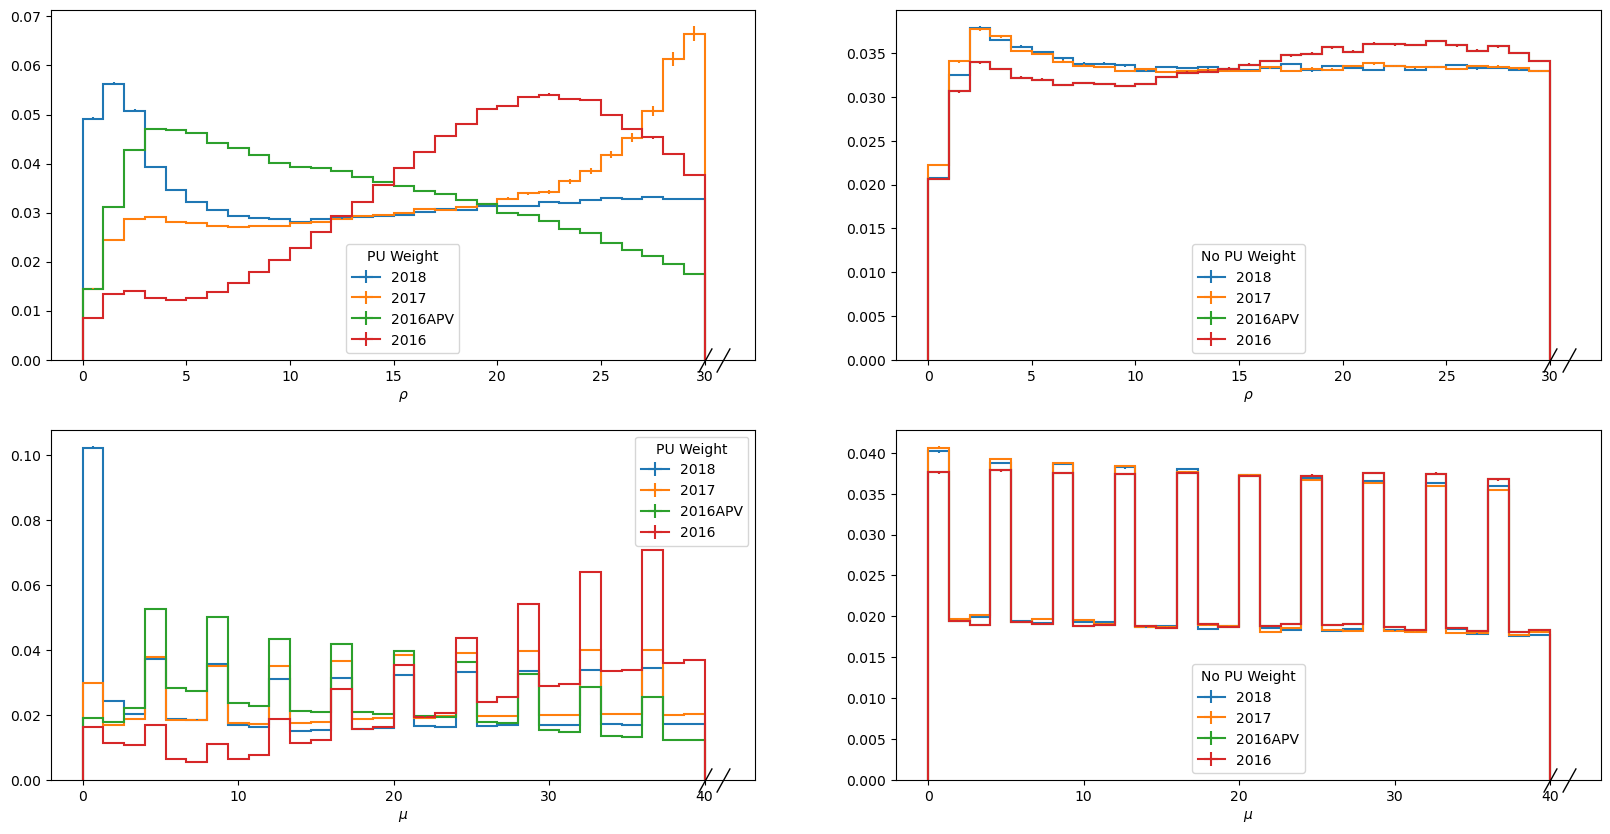

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

output["pileup_rho"].project('dataset', 'rho_fine').plot(ax=axs[0, 0], density=True)
output["pileup_rho_noweight"].project('dataset', 'rho_fine').plot(ax=axs[0, 1], density=True)

output["pileup_rho"].project('dataset', 'pileup_fine').plot(ax=axs[1, 0], density=True)
output["pileup_rho_noweight"].project('dataset', 'pileup_fine').plot(ax=axs[1, 1], density=True)

axs[0, 0].legend(title='PU Weight', frameon=True)
axs[0, 1].legend(title='No PU Weight', frameon=True)
axs[1, 0].legend(title='PU Weight', frameon=True)
axs[1, 1].legend(title='No PU Weight', frameon=True)
plt.show()

In [7]:
print(f".project('dataset', 'rho_fine') numpy shape    ==>    {output['pileup_rho'].project('dataset', 'rho_fine').to_numpy()[0].shape}")
print(f".project('dataset', 'pileup_fine') numpy shape    ==>    {output['pileup_rho'].project('dataset', 'pileup_fine').to_numpy()[0].shape}")

.project('dataset', 'rho_fine') numpy shape    ==>    (4, 30)
.project('dataset', 'pileup_fine') numpy shape    ==>    (4, 30)


### Fitting Histograms and Plotting Curves for a Given Transverse Momentum Range

In order to add a fit to our historgrams, we start by defining the edges, centers, and widths of the bins for our quantities of interest, which will be the `dataset`, `pt`, `frac`, `eta`, and `pileup`. We also define the define a dataset axis for future use:

In [8]:
histogram_1 = output["pt_reco_over_gen"]

for axis in histogram_1.axes:
    print(f"Axis type: {axis}\n")
    
dataset_axis = histogram_1.axes[0]

Axis type: StrCategory(['2018', '2017', '2016APV', '2016'], growth=True, name='dataset', label='Primary dataset')

Axis type: Variable(array([   10.,    11.,    12.,    13.,    14.,    15.,    17.,    20.,
          23.,    27.,    30.,    35.,    40.,    45.,    57.,    72.,
          90.,   120.,   150.,   200.,   300.,   400.,   550.,   750.,
        1000.,  1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  5000.,
       10000.]), name='pt', label='$p_{T}$ [GeV]')

Axis type: Regular(300, 0, 2, name='frac', label='Fraction')

Axis type: Variable([0, 0.261, 0.522, 0.783, 1.044, 1.305, 1.566, 1.74, 1.93, 2.043, 2.172, 2.322, 2.5, 2.65, 2.853, 2.964, 3.139, 3.489, 3.839, 5.191], name='eta', label='$\\eta$')

Axis type: Variable([0, 10, 20, 30, 40, 50, 60, 70, 80], name='pileup', label='$\\mu$')



In [9]:
bin_edges = []
bin_centers = []
bin_widths = []

eras = []

for i in range(len(dataset_axis)):
    era = dataset_axis[i]
    eras.append(era)

print(eras)

for axis in histogram_1.axes:
    bin_edges.append(axis.edges)
    bin_centers.append(axis.centers)
    bin_widths.append(axis.widths)

dataset_bin_edges, pt_bin_edges, frac_bin_edges, eta_bin_edges, pileup_bin_edges = bin_edges

dataset_bin_centers, pt_bin_centers, frac_bin_centers, eta_bin_centers, pileup_bin_centers = bin_centers

dataset_bin_widths, pt_bin_widths, frac_bin_widths, eta_bin_widths, pileup_bin_widths = bin_widths

['2018', '2017', '2016APV', '2016']


In [10]:
print(f"pt_bin_edges: {pt_bin_edges}\n\npt_bin_centers: {pt_bin_centers}\n\npt_bin_widths: {pt_bin_widths}\n")

pt_bin_edges: [   10.    11.    12.    13.    14.    15.    17.    20.    23.    27.
    30.    35.    40.    45.    57.    72.    90.   120.   150.   200.
   300.   400.   550.   750.  1000.  1500.  2000.  2500.  3000.  3500.
  4000.  5000. 10000.]

pt_bin_centers: [  10.5   11.5   12.5   13.5   14.5   16.    18.5   21.5   25.    28.5
   32.5   37.5   42.5   51.    64.5   81.   105.   135.   175.   250.
  350.   475.   650.   875.  1250.  1750.  2250.  2750.  3250.  3750.
 4500.  7500. ]

pt_bin_widths: [1.0e+00 1.0e+00 1.0e+00 1.0e+00 1.0e+00 2.0e+00 3.0e+00 3.0e+00 4.0e+00
 3.0e+00 5.0e+00 5.0e+00 5.0e+00 1.2e+01 1.5e+01 1.8e+01 3.0e+01 3.0e+01
 5.0e+01 1.0e+02 1.0e+02 1.5e+02 2.0e+02 2.5e+02 5.0e+02 5.0e+02 5.0e+02
 5.0e+02 5.0e+02 5.0e+02 1.0e+03 5.0e+03]



Having defined our bin dimensions, we now fit our histograms to a gaussian function and print its relevant parameters, such as its amplitude, mean, and width. It is important to note that we are projecting the $p_{T}$ fraction ratio over the entire dataset through `.project('dataset', 'frac')`, and so the distribution obtained contains the response over its whole respective era. Our next goal will be to create a fit for each $p_{T}$ bin, for each complete era, as this will allow us to obtain the widths (JER) and means (JES) of the graphs as functions of the transverse momentum bins for all four eras. To do so, we will first need to convert our `Hist` objects to numpy arrays.

Era: 2018    |    amplitude: 0.02820184147007416    |    mean: 0.9986284416185724    |    stdev: 0.07872636420539028    |    .project('dataset', 'frac'): (4, 300)

Era: 2017    |    amplitude: 0.027156940763222233    |    mean: 0.9965848161775862    |    stdev: 0.08025655794145704    |    .project('dataset', 'frac'): (4, 300)

Era: 2016APV    |    amplitude: 0.030566505189501936    |    mean: 0.9986055998442066    |    stdev: 0.07549797467922736    |    .project('dataset', 'frac'): (4, 300)

Era: 2016    |    amplitude: 0.02919790060088024    |    mean: 0.9935379337593813    |    stdev: 0.07834828291989465    |    .project('dataset', 'frac'): (4, 300)



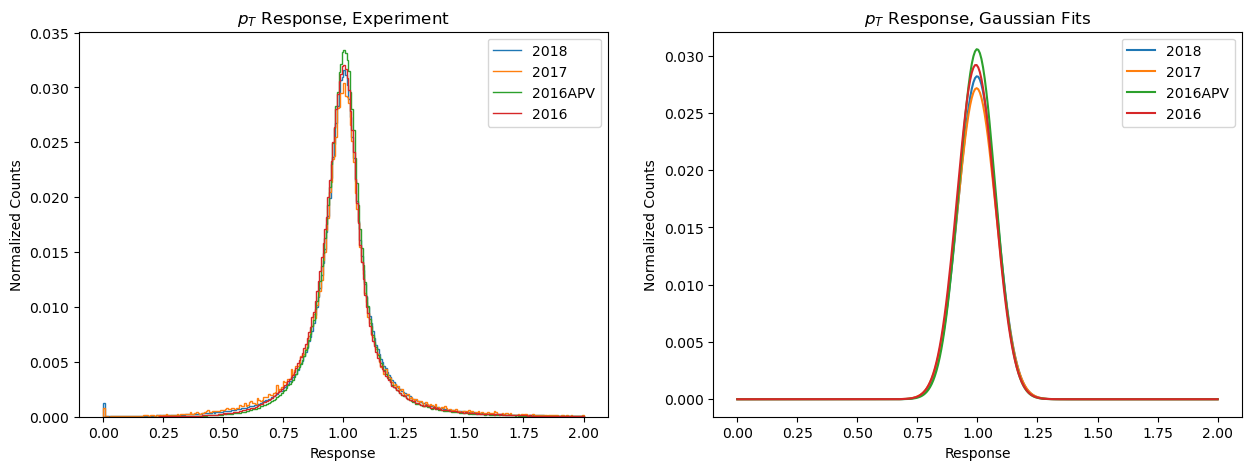

In [11]:
def gaussian_function(x, amplitude, mean, standard_dev):
    return amplitude * np.exp(- (x - mean)**2 / (2. * standard_dev**2))

histogram_frac_numpy, bin_edges = histogram_1.project('dataset', 'frac').to_numpy()[0], frac_bin_edges
bin_centers = frac_bin_centers
frac_xspace = np.linspace(0, 2, 300)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(len(eras)):
    normalized_y_vals = histogram_frac_numpy[i] / np.sum(histogram_frac_numpy[i])
    popt, pcov = curve_fit(gaussian_function, xdata=bin_centers, ydata=normalized_y_vals)
    print(f"Era: {eras[i]}    |    amplitude: {popt[0]}    |    mean: {popt[1]}    |    stdev: {popt[2]}    |    .project('dataset', 'frac'): {output['pt_reco_over_gen'].project('dataset', 'frac').to_numpy()[0].shape}\n")
    
    axs[0].stairs(normalized_y_vals, bin_edges, label=eras[i])
    axs[0].set_title("$p_T$ Response, Experiment")
    axs[0].set_xlabel("Response")
    axs[0].set_ylabel("Normalized Counts")
    axs[0].legend(frameon=True)
    
    axs[1].plot(frac_xspace, gaussian_function(frac_xspace, *popt), label=eras[i])
    axs[1].set_title("$p_T$ Response, Gaussian Fits")
    axs[1].set_xlabel("Response")
    axs[1].set_ylabel("Normalized Counts")
    axs[1].legend(frameon=True)

Our last task will be to record the means and widths of the gaussian fits for all $p_{T}$ bins, and then plot them as functions of the transverse momentum. We will then fit these JES/JER curves to the text files in the `jer_files` folder.

### Obtaining JES and JER Datapoints

Before continuing further, lets plot first all transverse momentum bins for each era; this will allow us to see $p_{T}$ distribution more clearly. To start with, we have to define a new histogram projection `.project('dataset', 'pt')` that contains all $p_{T}$ bins:

.project('dataset', 'pt') numpy shape    ==>    (4, 32)



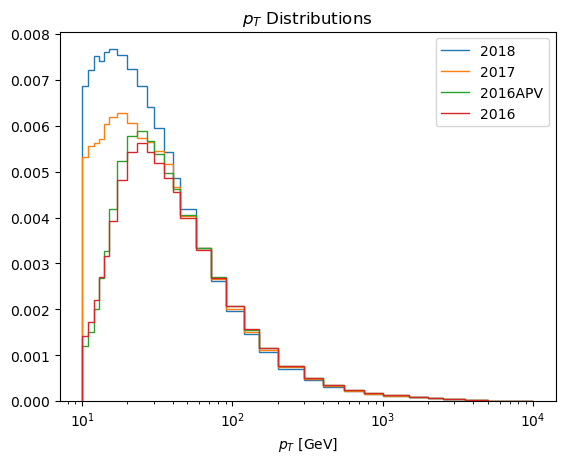

In [12]:
histogram_2 = output["pt_reco_over_gen"]
histogram_pt_numpy, bin_edges = histogram_2.project("dataset", "pt").to_numpy()[0], pt_bin_edges
bin_widths = pt_bin_widths

for i in range(len(eras)):
    normalized_y_vals = histogram_pt_numpy[i] / (np.sum(histogram_pt_numpy[i]) * bin_widths)
    plt.stairs(normalized_y_vals, bin_edges, label=eras[i])
    plt.title("$p_T$ Distributions")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.xscale("log")
    plt.legend(frameon=True)

print(f".project('dataset', 'pt') numpy shape    ==>    {histogram_2.project('dataset', 'pt').to_numpy()[0].shape}\n")

Now we define the projection `.project('pt', 'frac')` and plot the fractional transverse momentum response for all eras, for each $p_{T}$ bin:

.project('pt', 'frac') numpy shape    ==>    (32, 300)



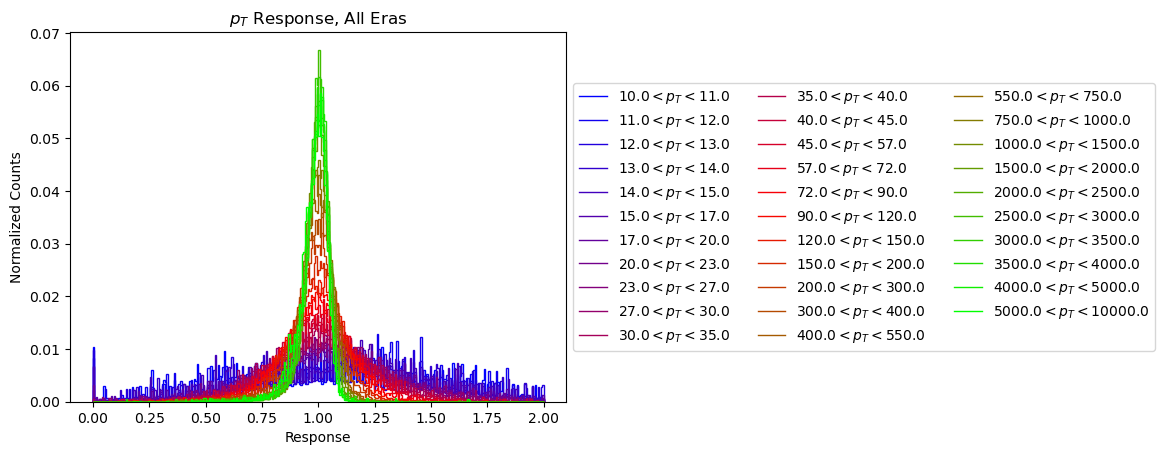

In [13]:
histogram_3 = output["pt_reco_over_gen"]
histogram_pt_frac_numpy, bin_edges = histogram_3.project("pt", "frac").to_numpy()[0], frac_bin_edges

color_map = plt.get_cmap('brg', len(pt_bin_centers))
    
for i in range(len(pt_bin_centers)):
    color = color_map(i / len(pt_bin_centers))
    normalized_y_vals = histogram_pt_frac_numpy[i] / np.sum(histogram_pt_frac_numpy[i])
    plt.stairs(normalized_y_vals, bin_edges, label=f"${pt_bin_edges[i]} <  p_{{T}}  < {pt_bin_edges[i + 1]}$", color=color)
    plt.title("$p_T$ Response, All Eras")
    plt.xlabel("Response")
    plt.ylabel("Normalized Counts")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)
    
print(f".project('pt', 'frac') numpy shape    ==>    {histogram_3.project('pt', 'frac').to_numpy()[0].shape}\n")

If we now define one last projection `.project('dataset', 'pt', 'frac')`, we can plot the $p_{T}$ response curves separately for each individual dataset:

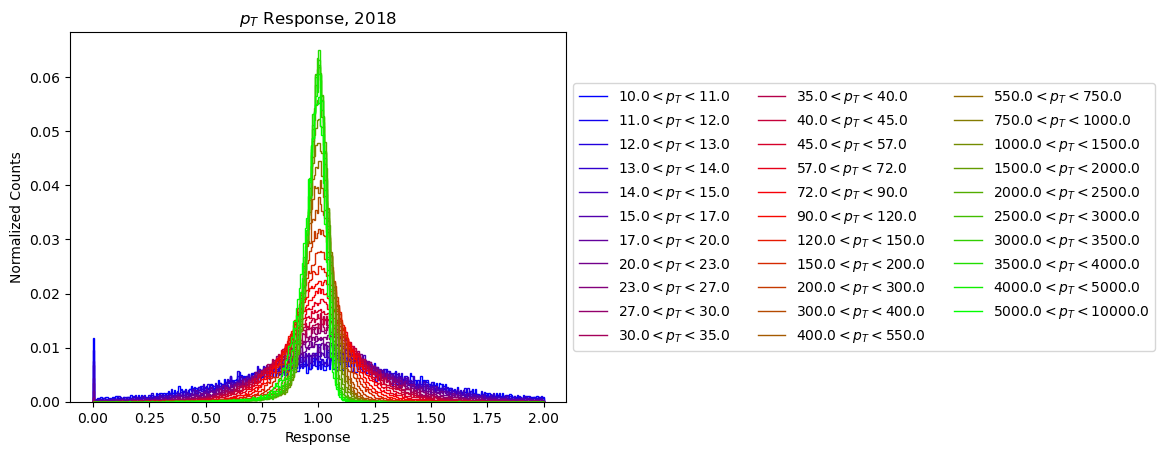

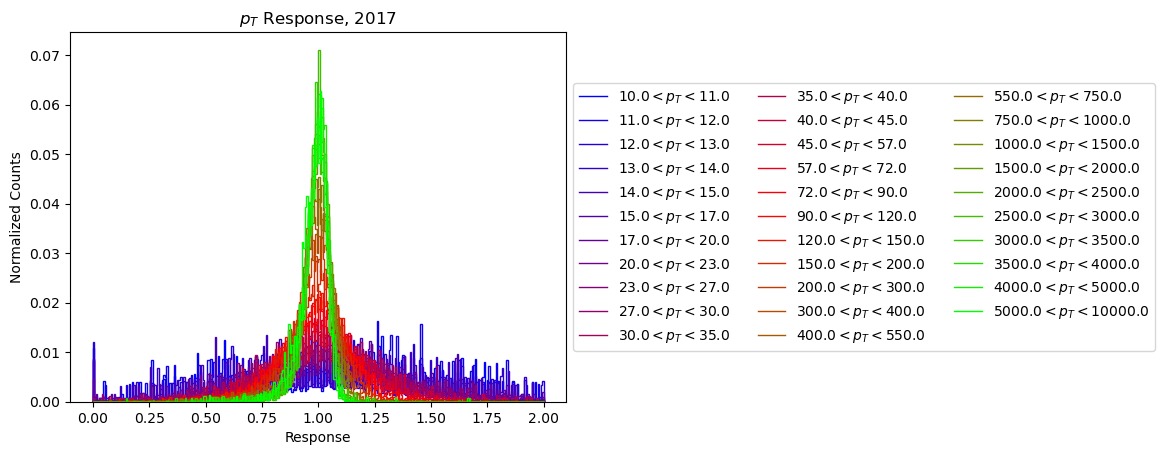

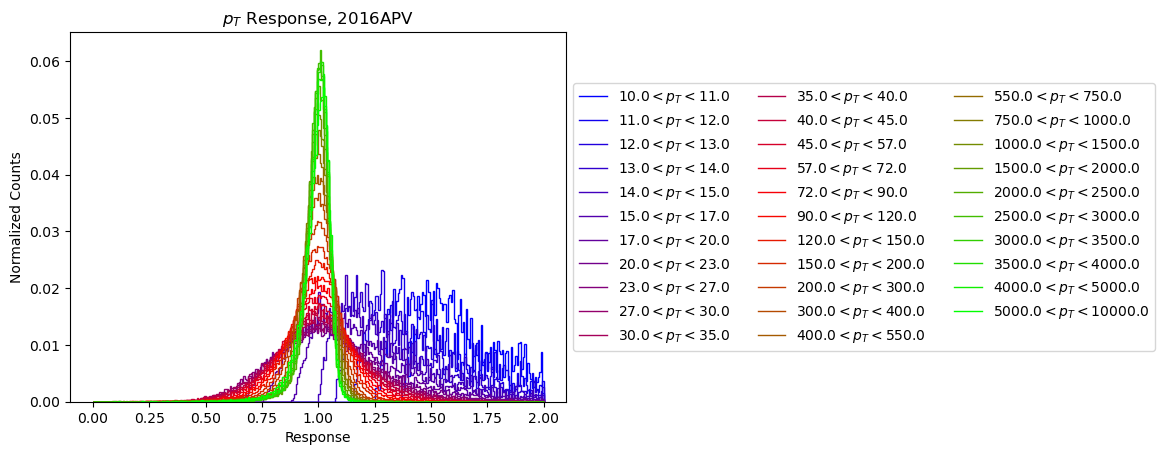

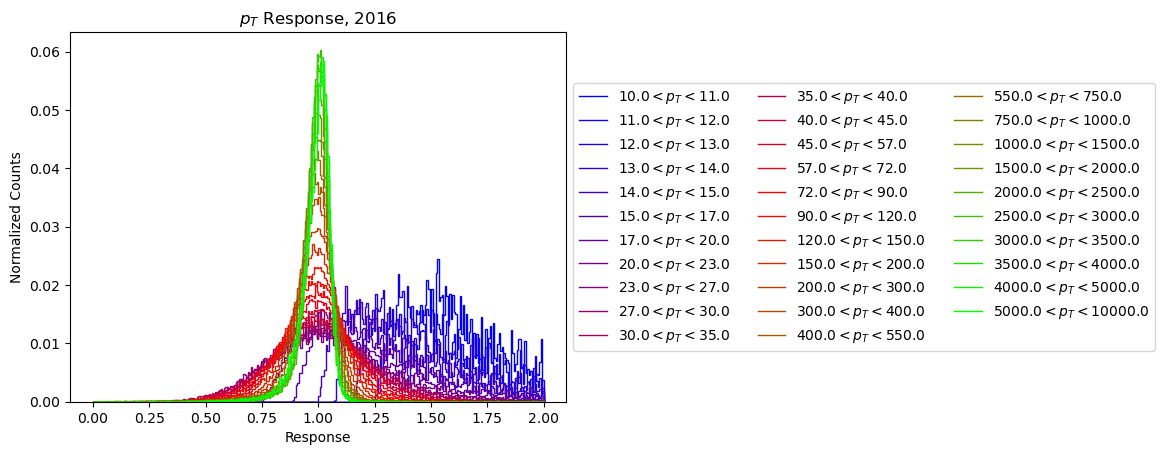

.project('dataset', 'pt', 'frac') numpy shape    ==>    (4, 32, 300)



In [14]:
histogram_4 = output["pt_reco_over_gen"]
histogram_dataset_pt_frac_numpy, bin_edges = histogram_4.project("dataset", "pt", "frac").to_numpy()[0], frac_bin_edges

color_map = plt.get_cmap('brg', len(pt_bin_centers))

for i, dataset in enumerate(histogram_dataset_pt_frac_numpy):
    for j, frac_vals in enumerate(dataset):
        color = color_map(j, len(pt_bin_centers))
        normalized_y_vals = frac_vals / np.sum(frac_vals)
        plt.stairs(normalized_y_vals, bin_edges, label=f"${pt_bin_edges[j]} <  p_{{T}}  < {pt_bin_edges[j + 1]}$", color=color)
        plt.title(f"$p_T$ Response, {histogram_4.project('dataset', 'pt', 'frac').axes[0][i]}")
        plt.xlabel("Response")
        plt.ylabel("Normalized Counts")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)
    plt.show()
    
print(f".project('dataset', 'pt', 'frac') numpy shape    ==>    {histogram_4.project('dataset', 'pt', 'frac').to_numpy()[0].shape}\n")

Finally, we fit all response curves of each era to a gaussian, and save their amplitudes, means, widths, and respective uncertainties to a CSV file:

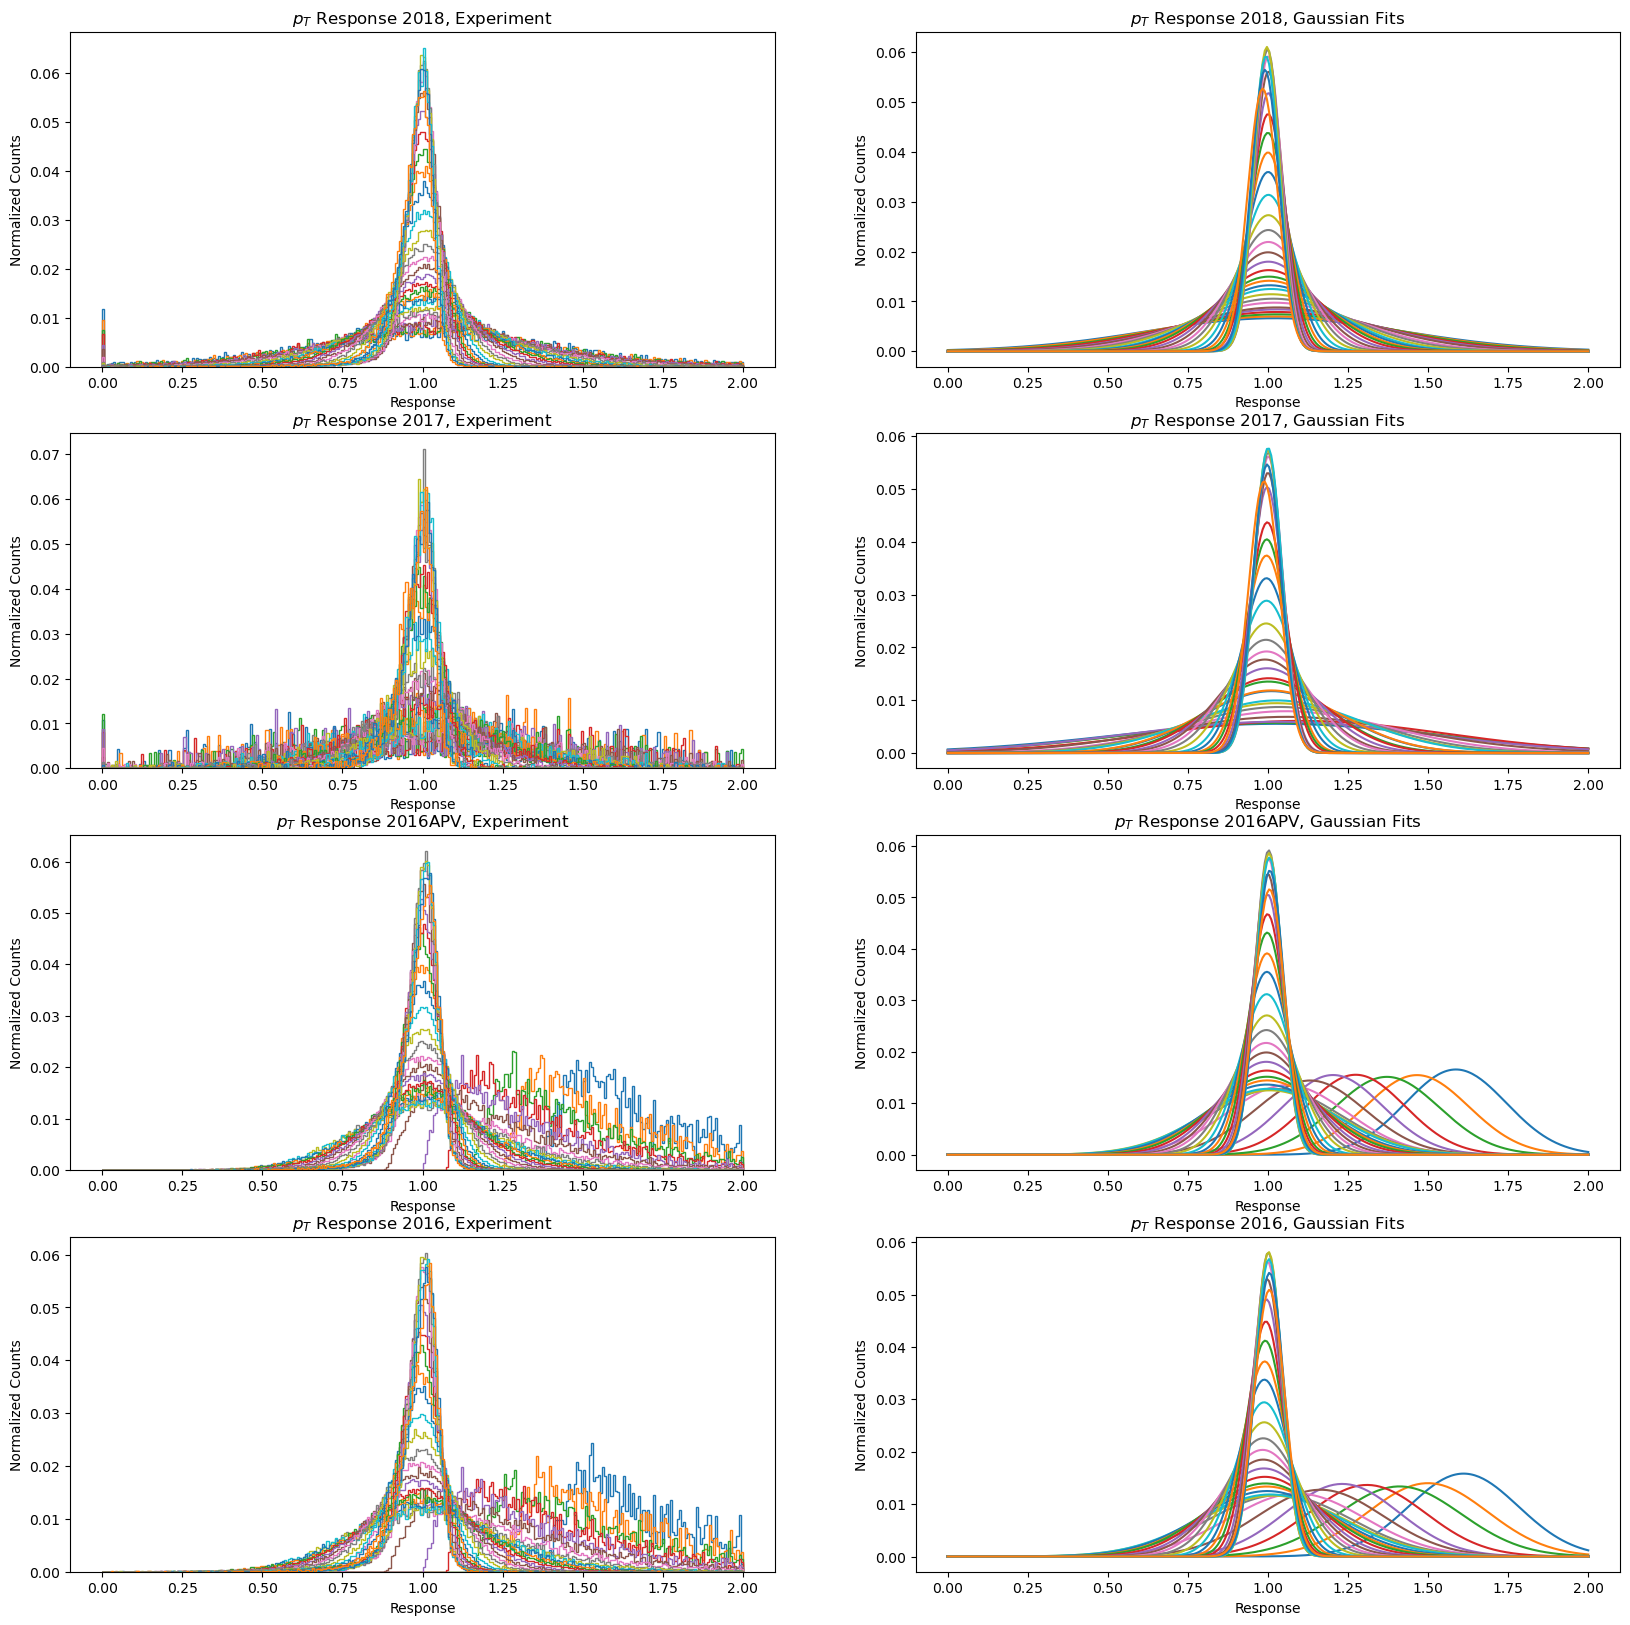

In [15]:
histogram_4 = output["pt_reco_over_gen"]
histogram_dataset_pt_frac_numpy, bin_edges = histogram_4.project("dataset", "pt", "frac").to_numpy()[0], frac_bin_edges
bin_centers = frac_bin_centers
frac_xspace = np.linspace(0, 2, 300)

fig, axs = plt.subplots(4, 2, figsize=(20, 20))

fit_parameters = {}

for i, dataset in enumerate(histogram_dataset_pt_frac_numpy):
    era_parameters = []
    for j, frac_vals in enumerate(dataset):
        normalized_y_vals = frac_vals / np.sum(frac_vals)
        popt, pcov = curve_fit(gaussian_function, xdata=bin_centers, ydata=np.nan_to_num(normalized_y_vals))
        era_parameters.append((popt, pcov))
            
        axs[i, 0].stairs(normalized_y_vals, bin_edges)
        axs[i, 0].set_title(f"$p_T$ Response {histogram_4.project('dataset', 'pt', 'frac').axes[0][i]}, Experiment")
        axs[i, 0].set_xlabel("Response")
        axs[i, 0].set_ylabel("Normalized Counts")
    
        axs[i, 1].plot(frac_xspace, gaussian_function(frac_xspace, *popt))
        axs[i, 1].set_title(f"$p_T$ Response {histogram_4.project('dataset', 'pt', 'frac').axes[0][i]}, Gaussian Fits")
        axs[i, 1].set_xlabel("Response")
        axs[i, 1].set_ylabel("Normalized Counts")
    fit_parameters[histogram_4.project('dataset', 'pt', 'frac').axes[0][i]] = era_parameters

In [16]:
output_dir = "./gaussian_fit_files/"
os.makedirs(output_dir, exist_ok=True)

for key, value in fit_parameters.items():
    filename = f"gaussian_parameters_{key}.csv"
    filepath = os.path.join(output_dir, filename)
    with open(filepath, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['popt', 'pcov'])       
        for popt, pcov in value:
            writer.writerow([popt, pcov])